In [1]:
!pip install torch torchvision matplotlib seaborn --quiet
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using:", device)


Using: cuda


In [2]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

seq_len, input_size, num_classes = 28, 28, 10


100%|██████████| 9.91M/9.91M [00:00<00:00, 64.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.52MB/s]


In [3]:
class SimpleRNNModel(nn.Module):
    def __init__(self, model_type="RNN"):
        super().__init__()
        if model_type == "RNN":
            self.rnn = nn.RNN(input_size, 128, batch_first=True)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size, 128, batch_first=True)
        else:
            self.rnn = nn.GRU(input_size, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
        self.model_type = model_type

    def forward(self, x):
        x = x.view(x.size(0), seq_len, input_size)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out)


In [4]:
def test_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

def get_all_weights(model):
    all_w = []
    for p in model.parameters():
        all_w.extend(p.detach().cpu().numpy().ravel())
    return np.array(all_w)


In [5]:
def train_and_plot(model_type="RNN", epochs=3):
    model = SimpleRNNModel(model_type).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    all_weights = []

    for ep in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
        acc = test_model(model)
        print(f"{model_type} Epoch {ep+1}/{epochs} | Test Accuracy: {acc:.4f}")
        all_weights.append(get_all_weights(model))

    plt.figure(figsize=(8,4))
    for i, w in enumerate(all_weights):
        sns.kdeplot(w, label=f'Epoch {i+1}')
    plt.title(f'Weight Evolution for {model_type}')
    plt.xlabel('Weight value')
    plt.legend()
    plt.show()


RNN Epoch 1/3 | Test Accuracy: 0.8493
RNN Epoch 2/3 | Test Accuracy: 0.8997
RNN Epoch 3/3 | Test Accuracy: 0.9441


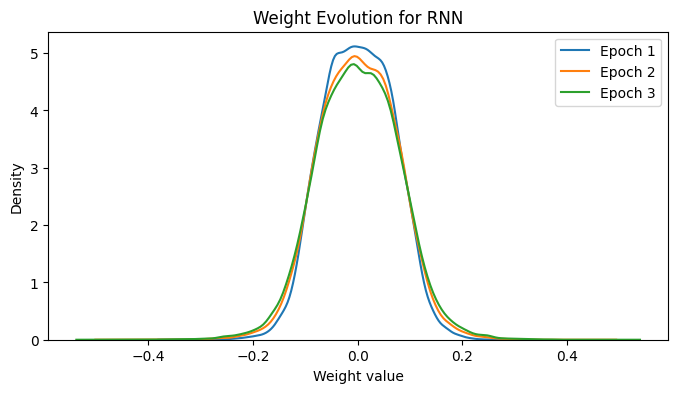

LSTM Epoch 1/3 | Test Accuracy: 0.9269
LSTM Epoch 2/3 | Test Accuracy: 0.9551
LSTM Epoch 3/3 | Test Accuracy: 0.9679


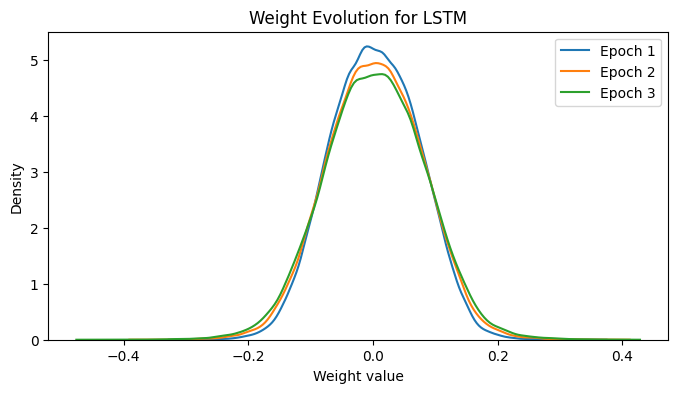

GRU Epoch 1/3 | Test Accuracy: 0.9172
GRU Epoch 2/3 | Test Accuracy: 0.9515
GRU Epoch 3/3 | Test Accuracy: 0.9673


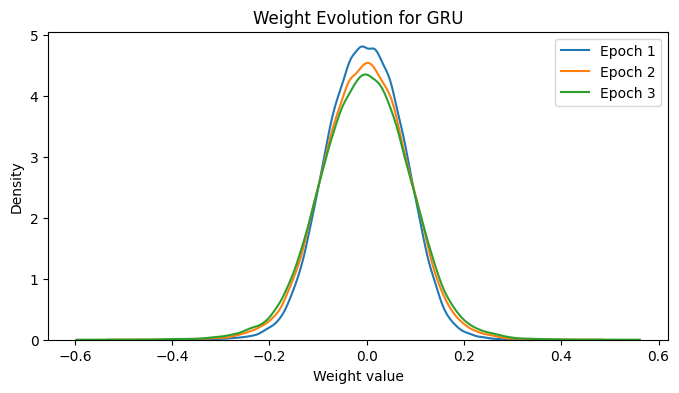

In [6]:
for model_type in ["RNN", "LSTM", "GRU"]:
    train_and_plot(model_type, epochs=3)


RNN weights change more unevenly across epochs.
LSTM and GRU weights evolve smoothly and stabilize faster because their gates control gradients.
LSTM learns slightly slower but more steadily, while GRU converges quickly with similar accuracy.